In [1]:
"""
Model-free Prediction and Control
Example of SARSA Learning (on-policy) and Q-Learning (off-policy) using OpenAI gym MountainCar enviornment (https://gym.openai.com/envs/MountainCar-v0/)
Bolei Zhou for IERG6130, with parts of code adapted from Moustafa Alzantot (malzantot@ucla.edu)
"""
import numpy as np
import gym
from gym import wrappers
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
off_policy = True # if True use off-policy q-learning update, if False, use on-policy SARSA update

In [3]:
n_states = 40
iter_max = 5000

In [4]:
initial_lr = 1.0 # Learning rate
min_lr = 0.003
gamma = 1.0
t_max = 10000
eps = 0.1

In [5]:
def run_episode(env, policy=None, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    if render:
        img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    for _ in range(t_max):
        if render:
            img.set_data(env.render(mode='rgb_array')) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if policy is None:
            action = env.action_space.sample()
        else:
            a,b = obs_to_state(env, obs)
            action = policy[a][b]
        obs, reward, done, _ = env.step(action)
        total_reward += gamma ** step_idx * reward
        step_idx += 1
        if done:
            break
    return total_reward

In [6]:
def obs_to_state(env, obs):
    """ Maps an observation to state """
    # we quantify the continous state space into discrete space
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / n_states
    a = int((obs[0] - env_low[0])/env_dx[0])
    b = int((obs[1] - env_low[1])/env_dx[1])
    return a, b

In [7]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)
env.seed(0)
np.random.seed(0)
if off_policy == True:
    print ('----- using Q Learning -----')
else:
    print('------ using SARSA Learning ---')

q_table = np.zeros((n_states, n_states, 3))
for i in range(iter_max):
    obs = env.reset()
    total_reward = 0
    ## eta: learning rate is decreased at each step
    eta = max(min_lr, initial_lr * (0.85 ** (i//100)))
    for j in range(t_max):
        a, b = obs_to_state(env, obs)
        if np.random.uniform(0, 1) < eps:
            action = np.random.choice(env.action_space.n)
        else:
            action = np.argmax(q_table[a][b])
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        # update q table
        a_, b_ = obs_to_state(env, obs)
        if off_policy == True:
            # use q-learning update (off-policy learning)
            q_table[a][b][action] = q_table[a][b][action] + eta * (reward + gamma *  np.max(q_table[a_][b_]) - q_table[a][b][action])
        else:
            # use SARSA update (on-policy learning)
            # epsilon-greedy policy on Q again
            if np.random.uniform(0,1) < eps:
                action_ = np.random.choice(env.action_space.n)
            else:
                action_ = np.argmax(q_table[a_][b_])
            q_table[a][b][action] = q_table[a][b][action] + eta * (reward + gamma *  q_table[a_][b_][action_] - q_table[a][b][action])
        if done:
            break
    if i % 200 == 0:
        print('Iteration #%d -- Total reward = %d.' %(i+1, total_reward))
solution_policy = np.argmax(q_table, axis=2)
solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(100)]
print("Average score of solution = ", np.mean(solution_policy_scores))

----- using Q Learning -----
Iteration #1 -- Total reward = -200.
Iteration #201 -- Total reward = -200.
Iteration #401 -- Total reward = -200.
Iteration #601 -- Total reward = -200.
Iteration #801 -- Total reward = -200.
Iteration #1001 -- Total reward = -200.
Iteration #1201 -- Total reward = -200.
Iteration #1401 -- Total reward = -200.
Iteration #1601 -- Total reward = -200.
Iteration #1801 -- Total reward = -200.
Iteration #2001 -- Total reward = -161.
Iteration #2201 -- Total reward = -200.
Iteration #2401 -- Total reward = -200.
Iteration #2601 -- Total reward = -200.
Iteration #2801 -- Total reward = -200.
Iteration #3001 -- Total reward = -153.
Iteration #3201 -- Total reward = -159.
Iteration #3401 -- Total reward = -200.
Iteration #3601 -- Total reward = -200.
Iteration #3801 -- Total reward = -200.
Iteration #4001 -- Total reward = -200.
Iteration #4201 -- Total reward = -200.
Iteration #4401 -- Total reward = -200.
Iteration #4601 -- Total reward = -200.
Iteration #4801 --

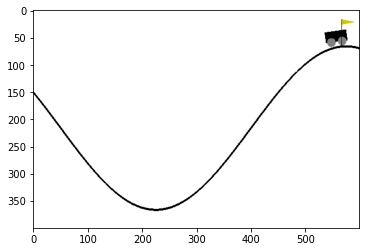

In [8]:
# Animate it
for _ in range(2):
    run_episode(env, solution_policy, True)
env.close()